<a href="https://colab.research.google.com/github/jacobstonelake/cv-image-classification/blob/main/image_classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1 - import libaries, load data, and display data info and sample images**

Shape of images dataset: (4750, 128, 128, 3)
Labels head:
                       Label
0  Small-flowered Cranesbill
1  Small-flowered Cranesbill
2  Small-flowered Cranesbill
3  Small-flowered Cranesbill
4  Small-flowered Cranesbill
Missing Values in Labels Dataset:
Label    0
dtype: int64


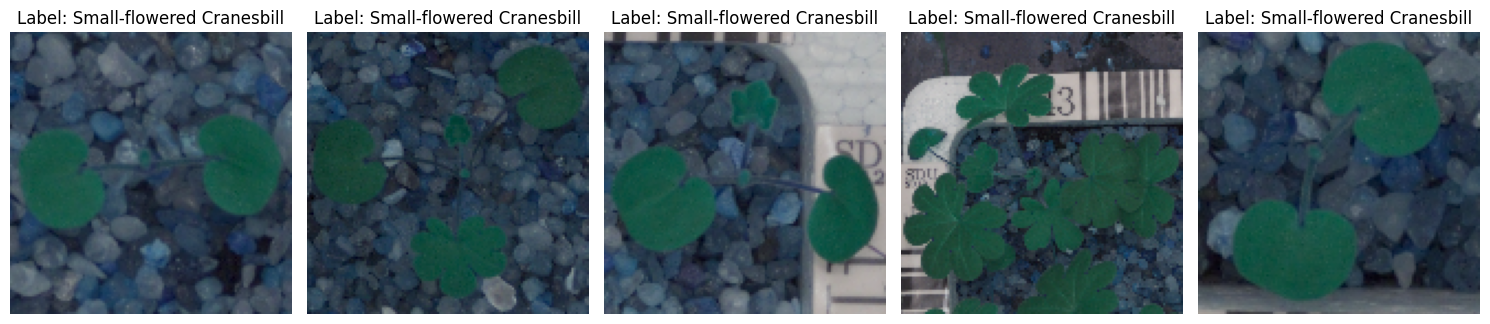

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

images = np.load('images.npy')
labels = pd.read_csv('Labels.csv')

print(f"Shape of images dataset: {images.shape}")
print(f"Labels head:\n{labels.head()}")

print("Missing Values in Labels Dataset:")
print(labels.isnull().sum())

def display_sample_images(images, labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels['Label'][i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(images, labels)


# Step 3: Perform EDA - visualize the class distribution, calculate the mean and STD of pixel values
**Reference:**
https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a

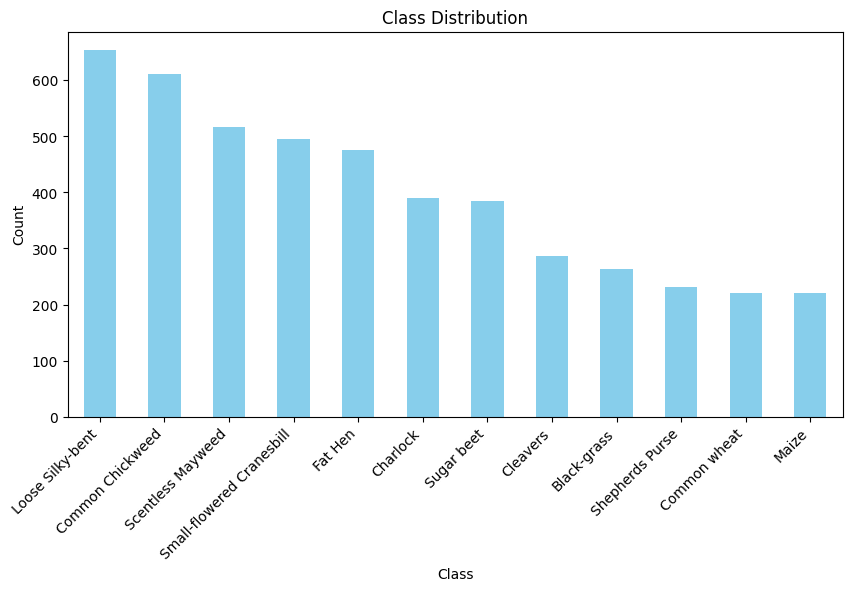


Class Distribution:
Label
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: count, dtype: int64
Mean pixel value: 70.04363745545504
Standard deviation of pixel values: 31.996876308515


In [ ]:
class_distribution.plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

print("\nClass Distribution:")
class_distribution = labels['Label'].value_counts()
print(class_distribution)


mean_pixel_value = images.mean()
std_pixel_value = images.std()
print(f"Mean pixel value: {mean_pixel_value}")
print(f"Standard deviation of pixel values: {std_pixel_value}")


# **Resize images and normalize pixel values**

In [ ]:

print("\nChecking and resizing images...")
image_shapes = [img.shape for img in images]
unique_shapes = set(image_shapes)
print(f"Unique image shapes: {unique_shapes}")

target_shape = (128, 128)  # Resizing to 128x128
if len(unique_shapes) > 1:
    images_resized = np.array([resize(img, target_shape, anti_aliasing=True) for img in images])
    print(f"Images resized to shape: {images_resized.shape}")
else:
    images_resized = images

images_normalized = images_resized / 255.0



Checking and resizing images...
Unique image shapes: {(128, 128, 3)}


# Step 5: Label encoding

In [ ]:
unique_classes = labels['Label'].unique()
label_to_index = {label: idx for idx, label in enumerate(unique_classes)}
y_indices = np.array([label_to_index[label] for label in labels['Label']])



# Step 5: Balance the dataset (I used weights)

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_indices),
    y=y_indices
)
class_weight_dict = {idx: weight for idx, weight in zip(np.unique(y_indices), class_weights)}
print(f"\nClass Weights: {class_weight_dict}")






Class Weights: {0: 0.7980510752688172, 1: 0.8333333333333334, 2: 1.7135642135642135, 3: 1.7911010558069382, 4: 0.6478450627386798, 5: 1.014957264957265, 6: 1.3792102206736354, 7: 0.7671188630490956, 8: 1.0281385281385282, 9: 1.7911010558069382, 10: 1.5050697084917617, 11: 0.605249745158002}


## Step 5: Split data for training and testing

In [ ]:
X_train, X_test, y_train_indices, y_test_indices = train_test_split(
    images_normalized, y_indices, test_size=0.2, random_state=42, stratify=y_indices
)

# Step 6: One-hot encoding, augment data for better results

In [ ]:
y_train = to_categorical(y_train_indices, num_classes=len(unique_classes))
y_test = to_categorical(y_test_indices, num_classes=len(unique_classes))

train_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
)

val_augmentation = ImageDataGenerator()

# Ensure Data is in correct format

In [ ]:
train_gen = train_augmentation.flow(X_train, y_train, batch_size=32, shuffle=True)
val_gen = val_augmentation.flow(X_test, y_test, batch_size=32)

In [ ]:
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_test.shape}, {y_test.shape}")
print(images_normalized.shape)

Training data shape: (3800, 128, 128, 3), (3800, 12)
Validation data shape: (950, 128, 128, 3), (950, 12)
(4750, 128, 128, 3)


# Step 7: Model Building

In [ ]:
def enhanced_cnn():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5, 5), activation='relu', kernel_regularizer=l2(0.005)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))

    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(len(unique_classes), activation='softmax'))

    return model


In [ ]:

def improved_cnn():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5, 5), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(len(unique_classes), activation='softmax'))
    return model


# Step 8: Train model

In [ ]:
# Compile Model
model = improved_cnn()
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=45,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/45
119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 185ms/step - accuracy: 0.2094 - loss: 4.5610 - val_accuracy: 0.0463 - val_loss: 4.0382 - learning_rate: 0.0010
Epoch 2/45
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.3825 - loss: 2.7484 - val_accuracy: 0.0463 - val_loss: 4.3347 - learning_rate: 0.0010
Epoch 3/45
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.4181 - loss: 2.2526 - val_accuracy: 0.1074 - val_loss: 2.8795 - learning_rate: 0.0010
Epoch 4/45
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.4578 - loss: 1.9089 - val_accuracy: 0.1558 - val_loss: 2.9521 - learning_rate: 0.0010
Epoch 5/45
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.4851 - loss: 1.7747 - val_accuracy: 0.1274 - val_loss: 2.7139 - learning_rate: 0.0010
Epoch 6/45
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.5037 - loss: 1.6489 - val_accuracy: 0.2568 - val_loss: 2.9793 - learning_rate: 0.0010
Epoch 7/45
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.5

# Step 9: Model performance eval

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7683 - loss: 0.8641
Test Accuracy: 0.77, Test Loss: 0.89


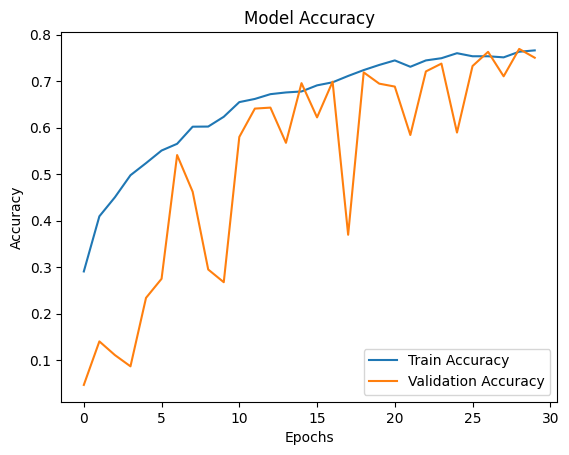

In [ ]:

test_loss, test_accuracy = model.evaluate(val_gen, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.7694736842105263
Precision: 0.7943187569645234
Recall: 0.7694736842105263


Confusion Matrix:
[[ 79   1  11   0   3   0   3   0   1   0   0   1]
 [  8  63   0   2   1   9   7   0   3   1   1   0]
 [  2   0  31   0   2   0   1  10   0   0   0   0]
 [  0   0   0  41   1   0   1   0   0   1   0   0]
 [  1   0   6   0 113   0   0   2   0   0   0   0]
 [  6   0   1   0   0  58  10   1   1   1   0   0]
 [  1   0   0   0   1   2  54   0   0   0   0   0]
 [  0   1  26   1   0   0   1  72   1   0   1   0]
 [  0   5   1   0   0   0   3   2  64   1   0   1]
 [  0   0   0   2   0   3   0   0   2  36   0   1]
 [  0   0   1   5   0   0   0   1   1   0  30  15]
 [  0   1   1   0   0   0   0   5   0   0  34  90]]


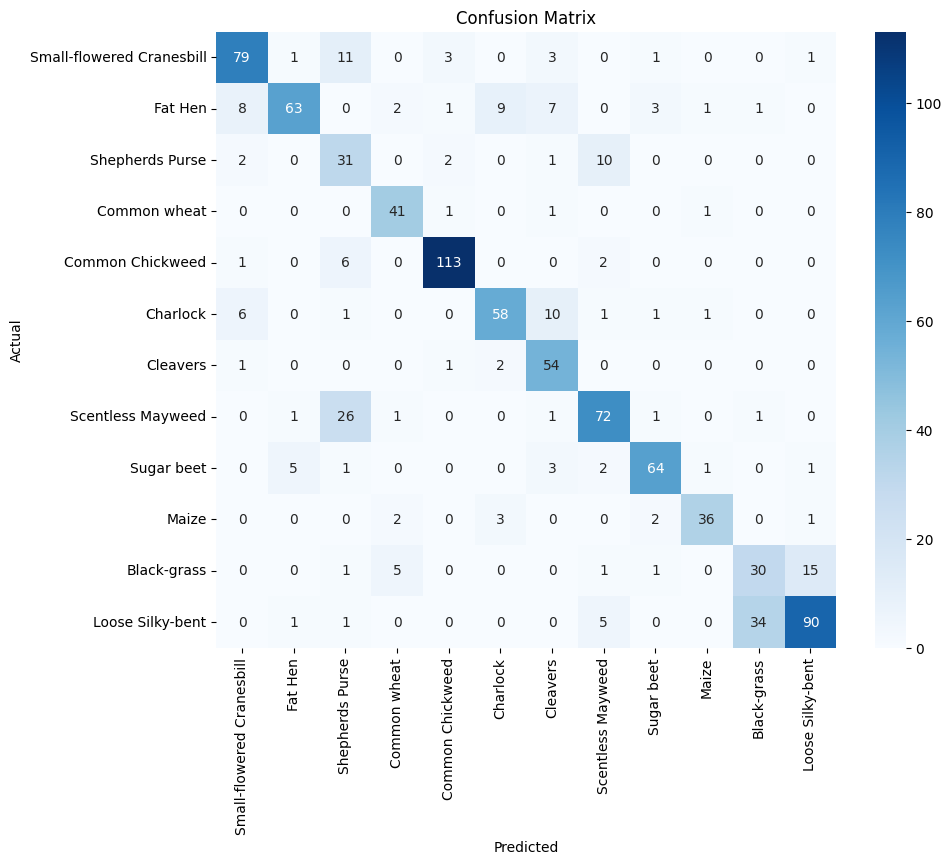

In [ ]:

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)
print("Confusion Matrix:")
print(cm)



plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
